<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#To-Do" data-toc-modified-id="To-Do-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>To Do</a></span></li><li><span><a href="#Turning-admissions-into-outflows_data" data-toc-modified-id="Turning-admissions-into-outflows_data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Turning admissions into outflows_data</a></span></li><li><span><a href="#Turning-sentence_length-into-transitions_data" data-toc-modified-id="Turning-sentence_length-into-transitions_data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Turning sentence_length into transitions_data</a></span></li><li><span><a href="#Turn-population-into-total_population_data" data-toc-modified-id="Turn-population-into-total_population_data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Turn population into total_population_data</a></span></li><li><span><a href="#Debugging" data-toc-modified-id="Debugging-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Debugging</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [8]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
# pd.set_option('max_columns', 100)

In [9]:
admissions = pd.read_csv(
    '../state/LA/LA_data/LA Data - Admissions by crime type.csv',
    index_col=0
)
age_at_admission = pd.read_csv(
    '../state/LA/LA_data/LA Data - Age at admission by crime type x race.csv',
    index_col=0
)
age_today = pd.read_csv(
    '../state/LA/LA_data/LA Data - Age today by crime type x race.csv',
    index_col=0
)
population = pd.read_csv(
    '../state/LA/LA_data/LA Data - Population by crime type.csv',
    index_col=0
)
recidivism = pd.read_csv(
    '../state/LA/LA_data/LA Data - Recidivism.csv',
    index_col=0
)
releases = pd.read_csv(
    '../state/LA/LA_data/LA Data - Releases by crime type.csv',
    index_col=0
)

sentence_length = pd.read_csv(
    '../state/LA/LA_data/LA Data - Sentence Length by crime type x race.csv',
    index_col=0
)

# To Do
- Transitions data
    - check on rounding question
    - what to do about 50+ / Life / Death
    - include recidivism
    
- Total population data
    - does time_step have to be an integer?
    - include DOC projections? I think no

# Turning admissions into outflows_data

In [10]:
admissions

,violent,property,drug,Sex nonviolent,others,total,Unnamed: 7,Unnamed: 8
https://doc.louisiana.gov/about-the-dpsc/annual-statistics/,,,,,,,,
1994,1793.0,4087.0,4493.0,NaN,1691.0,12064,0,12064.0
1995,1843.0,4043.0,4837.0,NaN,1905.0,12628,0,12628.0
1996,1888.0,4423.0,5009.0,NaN,2210.0,13530,0,13530.0
1997,2252.0,4837.0,5547.0,NaN,2420.0,15056,0,15056.0
1998,2496.0,4955.0,5970.0,NaN,2207.0,15628,0,15628.0
1999,3064.0,5342.0,5348.0,NaN,1607.0,15361,0,15361.0
2000,3499.0,5428.0,5521.0,NaN,1590.0,16038,8,16046.0
2001,3171.0,5339.0,5465.0,NaN,1598.0,15573,0,15573.0
2002,2969.0,5278.0,5737.0,NaN,1575.0,15559,-11,15548.0


In [11]:
admissions_jr = admissions.copy()

#adding the sex nonviolent category to Other because it only existed as it's own category since 2016
admissions_jr['Sex nonviolent'] = admissions_jr['Sex nonviolent'].fillna(0)
admissions_jr['others'] += admissions_jr['Sex nonviolent']
admissions_jr = admissions_jr.drop(['Sex nonviolent', 'Unnamed: 7', 'Unnamed: 8', 'total'], axis = 1)

#2021 and 2022 were both NA for all crime types
admissions_jr = admissions_jr.drop([2021, 2022]) 

# time_step
admissions_jr.index.names = ['year']
admissions_jr = admissions_jr.reset_index()
admissions_jr['time_step'] = (admissions_jr.year - 2020)

admissions_jr

,year,violent,property,drug,others,time_step
0,1994,1793.0,4087.0,4493.0,1691.0,-26
1,1995,1843.0,4043.0,4837.0,1905.0,-25
2,1996,1888.0,4423.0,5009.0,2210.0,-24
3,1997,2252.0,4837.0,5547.0,2420.0,-23
4,1998,2496.0,4955.0,5970.0,2207.0,-22
5,1999,3064.0,5342.0,5348.0,1607.0,-21
6,2000,3499.0,5428.0,5521.0,1590.0,-20
7,2001,3171.0,5339.0,5465.0,1598.0,-19
8,2002,2969.0,5278.0,5737.0,1575.0,-18
9,2003,2859.0,5185.0,6279.0,1810.0,-17


In [12]:
2305 + 3015 + 2877 + 1493

9690

In [13]:
#crime_type
admissions_jr_the_second = pd.DataFrame()
crime_types = ['violent', 'property', 'drug', 'others']
for i, row in admissions_jr.iterrows():
    for j in crime_types:
        new_rows = pd.DataFrame({
            'time_step': [row['time_step'] * 12 + i for i in range(12)],
            'crime_type': [j] * 12,
            'total_population': [row[j] / 12] * 12,
            'compartment': ['pretrial'] * 12,
            'outflow_to': ['prison'] * 12
        })
        admissions_jr_the_second = admissions_jr_the_second.append(new_rows, ignore_index=True)

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/3356204832.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  admissions_jr_the_second = admissions_jr_the_second.append(new_rows, ignore_index=True)


In [14]:
admissions_jr_the_second.head()

,time_step,crime_type,total_population,compartment,outflow_to
0,-312.0,violent,149.416667,pretrial,prison
1,-311.0,violent,149.416667,pretrial,prison
2,-310.0,violent,149.416667,pretrial,prison
3,-309.0,violent,149.416667,pretrial,prison
4,-308.0,violent,149.416667,pretrial,prison


In [15]:
outflows_data = admissions_jr_the_second
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data

,time_step,crime_type,total_population,compartment,outflow_to
0,-312,violent,149.416667,pretrial,prison
1,-311,violent,149.416667,pretrial,prison
2,-310,violent,149.416667,pretrial,prison
3,-309,violent,149.416667,pretrial,prison
4,-308,violent,149.416667,pretrial,prison
...,...,...,...,...,...
1291,7,others,124.416667,pretrial,prison
1292,8,others,124.416667,pretrial,prison
1293,9,others,124.416667,pretrial,prison
1294,10,others,124.416667,pretrial,prison


<AxesSubplot: xlabel='time_step'>

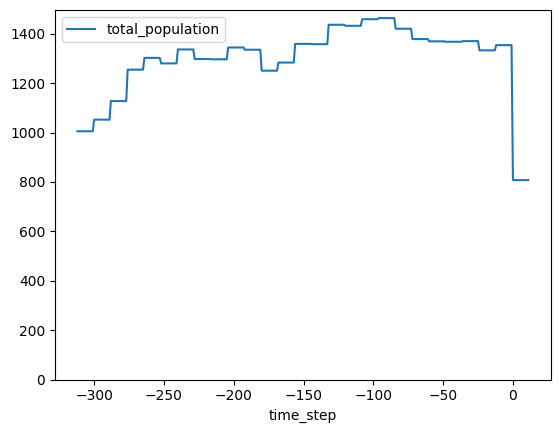

In [16]:
outflows_data.groupby('time_step').sum().plot(ylim=[0,None])

# Turning sentence_length into transitions_data

In [17]:
sentence_length

,Black,Black.1,Black.2,Black.3,White,White.1,White.2,White.3
NaN,Violent,Drug,Property,Other,Violent,Drug,Property,Other
0-2,193,157,143,168,113,316,183,172
3-4,291,178,236,215,127,202,280,181
5-6,634,270,320,425,274,242,316,384
7-10,1479,570,387,585,524,284,401,583
11-16,1322,424,230,353,340,115,149,319
17-20,1094,225,64,180,375,53,43,204
21-30,1443,146,49,125,544,30,27,185
31-50,1424,70,12,48,483,11,14,75
50+,741,25,2,23,181,4,3,31


In [18]:
transitions_data = sentence_length.copy()
transitions_data = transitions_data.iloc[1:]

for i in range(len(crime_types)):
    num = '' if i == 0 else '.' + str(i)
    transitions_data[crime_types[i]] = transitions_data['Black' + num].astype(float) + transitions_data['White' + num].astype(float)
    
transitions_data = transitions_data[crime_types]

transitions_data.loc['50-50'] = transitions_data.loc['50+'] + transitions_data.loc['death'] + transitions_data.loc['life']
transitions_data = transitions_data.drop(['death', 'life', '50+'])

transitions_data

,violent,property,drug,others
0-2,306.0,473.0,326.0,340.0
3-4,418.0,380.0,516.0,396.0
5-6,908.0,512.0,636.0,809.0
7-10,2003.0,854.0,788.0,1168.0
11-16,1662.0,539.0,379.0,672.0
17-20,1469.0,278.0,107.0,384.0
21-30,1987.0,176.0,76.0,310.0
31-50,1907.0,81.0,26.0,123.0
50-50,5262.0,83.0,44.0,85.0


In [19]:
transitions_data = transitions_data.reset_index()

In [20]:
transitions_data = transitions_data.rename(columns={'index': 'compartment_duration'})

In [21]:
def punk_jr(compartment_duration):
    compartment_duration = compartment_duration.split('-')
    start = float(compartment_duration[0])
    final_duration = start
    
    if len(compartment_duration) > 1:
        end = float(compartment_duration[1])
        final_duration = -start + end + 1
        
    return final_duration * 12

transitions_data_jr = transitions_data.copy()
transitions_data_jr["months_in_group"] = transitions_data_jr['compartment_duration'].apply(punk_jr)


# disallow sentences less than 6 months
transitions_data_jr.loc[0, 'compartment_duration'] = '0.5-2'
transitions_data_jr.loc[0, 'months_in_group'] = 30.0

transitions_data_jr

,compartment_duration,violent,property,drug,others,months_in_group
0,0.5-2,306.0,473.0,326.0,340.0,30.0
1,3-4,418.0,380.0,516.0,396.0,24.0
2,5-6,908.0,512.0,636.0,809.0,24.0
3,7-10,2003.0,854.0,788.0,1168.0,48.0
4,11-16,1662.0,539.0,379.0,672.0,72.0
5,17-20,1469.0,278.0,107.0,384.0,48.0
6,21-30,1987.0,176.0,76.0,310.0,120.0
7,31-50,1907.0,81.0,26.0,123.0,240.0
8,50-50,5262.0,83.0,44.0,85.0,12.0


In [22]:
transitions_data_jr.property.sum() + transitions_data_jr.violent.sum() + transitions_data_jr.drug.sum() + transitions_data_jr.others.sum()

26483.0

In [23]:
transitions_jr_the_second = pd.DataFrame()
crime_types = ['violent', 'property', 'drug', 'others']
prev_months = 6

for i, row in transitions_data_jr.iterrows():
    for j in crime_types:
        for month in range(int(prev_months), int(prev_months + row['months_in_group'])):
            new_row = {'compartment_duration': month, 'crime_type': j, 'total_population': row[j]/(month * row['months_in_group']),
                   'compartment': 'prison', 'outflow_to': 'release'}
            transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
    prev_months += row['months_in_group']

transitions_jr_the_second = transitions_jr_the_second.append({'compartment_duration': 1, 'crime_type': 'violent', 'total_population': 1, 'compartment': 'release', 'outflow_to': 'release'}, ignore_index = True)
transitions_jr_the_second = transitions_jr_the_second.append({'compartment_duration': 1, 'crime_type': 'property', 'total_population': 1, 'compartment': 'release', 'outflow_to': 'release'}, ignore_index = True)
transitions_jr_the_second = transitions_jr_the_second.append({'compartment_duration': 1, 'crime_type': 'drug', 'total_population': 1, 'compartment': 'release', 'outflow_to': 'release'}, ignore_index = True) 
transitions_jr_the_second = transitions_jr_the_second.append({'compartment_duration': 1, 'crime_type': 'others', 'total_population': 1, 'compartment': 'release', 'outflow_to': 'release'}, ignore_index = True)   

transitions_jr_the_second.compartment_duration = transitions_jr_the_second.compartment_duration.astype(float)
transitions_jr_the_second.total_population = transitions_jr_the_second.total_population.astype(float)




transitions_jr_the_second 

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: 

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: 

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: 

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transitions_jr_the_second = transitions_jr_the_second.append(new_row, ignore_index=True)
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_8296/1361144199.py:10: 

,compartment_duration,crime_type,total_population,compartment,outflow_to
0,6.0,violent,1.700000,prison,release
1,7.0,violent,1.457143,prison,release
2,8.0,violent,1.275000,prison,release
3,9.0,violent,1.133333,prison,release
4,10.0,violent,1.020000,prison,release
...,...,...,...,...,...
2471,623.0,others,0.011370,prison,release
2472,1.0,violent,1.000000,release,release
2473,1.0,property,1.000000,release,release
2474,1.0,drug,1.000000,release,release


In [24]:
#scale down compartment_duration to convert from sentence length to LOS.
avg_LOS = (
    transitions_jr_the_second.compartment_duration * transitions_jr_the_second.total_population
).sum()/transitions_jr_the_second.total_population.sum()

#actual LOS taken from https://www.pewtrusts.org/-/media/legacy/uploadedfiles/pcs_assets/2012/prisontimeservedlouisianapdf.pdf
LOS_scale_factor = 2.5 * 12 / avg_LOS
transitions_jr_the_second.compartment_duration *= LOS_scale_factor

#life sentences should not get shortened
transitions_jr_the_second.loc[
    transitions_jr_the_second.compartment_duration >= 50 * 12 * LOS_scale_factor, 'compartment_duration'
] = 50.0 * 12

#sentences shouldn't get shorter than six months
transitions_jr_the_second.loc[
    transitions_jr_the_second.compartment_duration < 6, 'compartment_duration'
] = 6.0

LOS_scale_factor

0.3032363032000465

<AxesSubplot: xlabel='compartment_duration'>

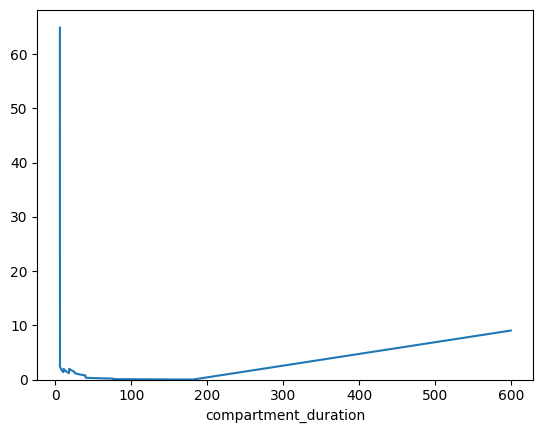

In [25]:
transitions_jr_the_second.groupby('compartment_duration').sum()['total_population'].plot(x='compartment_duration', y='total_population', ylim=[0, None])

# Turn population into total_population_data

In [26]:
total_population = population.copy()
total_population = total_population.reset_index()
total_population = total_population[:198]
# total_population['year'] = (admissions_jr['https://doc.louisiana.gov/about-the-dpsc/annual-statistics/'] - 2019)
# total_population = total_population.drop(
  #   ['https://doc.louisiana.gov/about-the-dpsc/annual-statistics/', 'State Facilities', 'Local Facilities'],
  #   axis = 1)


TIMESTEP_START = 2020;
MOTHS = { 'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun': 5, 'Jul':6, 'Aug':7, 'Sep':8, 'Oct': 9, 'Nov':10, 'Dec':11 }

total_population = total_population.rename(columns={'https://doc.louisiana.gov/about-the-dpsc/annual-statistics/':'Year', 'Unnamed: 1':'Month', 'State Facilities':'total_population'})

total_population.Year = total_population.Year.astype(int)
total_population.total_population = total_population.total_population.apply(lambda x: x.replace(',', '')).astype(float)


# def timeStep(row):
#     year  = row['Year']
#     month = row['Month']
    
#     timestep = 12 * (year - TIMESTEP_START) + MOTHS[month]
    
#     return timestep


# create a new timestep column
# total_population['timestep'] = total_population.apply(timeStep, axis=1)

total_population['time_step'] = (total_population['Year'] - TIMESTEP_START) * 12 + total_population['Month'].map(MOTHS)
total_population['compartment'] = 'prison'
total_population

,Year,Month,total_population,Local Facilities,Total,time_step,compartment
0,2005,Jan,19300.0,17066,36366,-180,prison
1,2005,Feb,19439.0,17378,36817,-179,prison
2,2005,Mar,19569.0,17327,36896,-178,prison
3,2005,Apr,19435.0,17431,36866,-177,prison
4,2005,May,19484.0,17708,37192,-176,prison
5,2005,Jun,19591.0,17645,37236,-175,prison
6,2005,Jul,19589.0,17685,37274,-174,prison
7,2005,Aug,25378.0,16819,42197,-173,prison
8,2005,Sep,25437.0,17953,43390,-172,prison
9,2005,Oct,23045.0,17558,40603,-171,prison


In [27]:
population_cleaned = total_population[['total_population', 'time_step', 'compartment']]

population_cleaned


,total_population,time_step,compartment
0,19300.0,-180,prison
1,19439.0,-179,prison
2,19569.0,-178,prison
3,19435.0,-177,prison
4,19484.0,-176,prison
5,19591.0,-175,prison
6,19589.0,-174,prison
7,25378.0,-173,prison
8,25437.0,-172,prison
9,23045.0,-171,prison


In [28]:
simulation_tag = "la_baseline"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_jr_the_second,
    population_cleaned,
    '../state/LA/baseline_configuration.yaml',
)

/Users/ayeshakhawaja/Downloads/StanfordDecriminalizationCoalition/recidiviz-data-sdc/recidiviz/calculator/modeling/population_projection/sdc_notebooks/../../../../../recidiviz/calculator/modeling/population_projection/utils/spark_bq_utils.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  params["data_df"]["simulation_tag"] = simulation_tag
/Users/ayeshakhawaja/Downloads/StanfordDecriminalizationCoalition/recidiviz-data-sdc/recidiviz/calculator/modeling/population_projection/sdc_notebooks/../../../../../recidiviz/calculator/modeling/population_projection/utils/spark_bq_utils.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

# Debugging

<AxesSubplot: xlabel='time_step'>

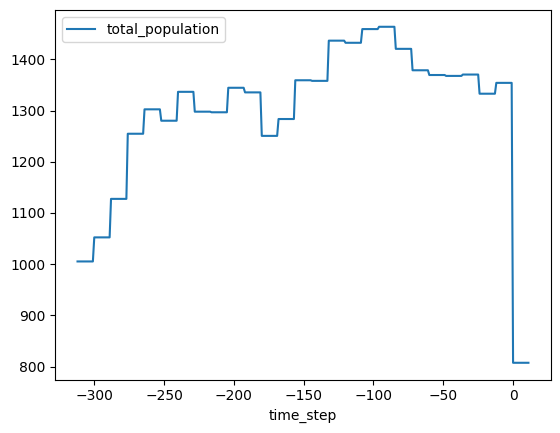

In [30]:
outflows_data.groupby('time_step').sum().plot()

<AxesSubplot: xlabel='compartment_duration'>

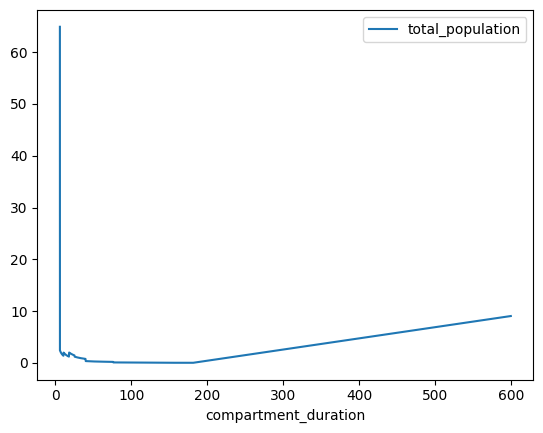

In [31]:
transitions_jr_the_second.groupby('compartment_duration').sum().plot()

In [32]:
transitions_jr_the_second.head()

,compartment_duration,crime_type,total_population,compartment,outflow_to,simulation_tag,date_created,crime,age,race
0,6.0,violent,1.700000,prison,release,la_baseline,2022-09-23 22:25:01.878449,None,None,None
1,6.0,violent,1.457143,prison,release,la_baseline,2022-09-23 22:25:01.878449,None,None,None
2,6.0,violent,1.275000,prison,release,la_baseline,2022-09-23 22:25:01.878449,None,None,None
3,6.0,violent,1.133333,prison,release,la_baseline,2022-09-23 22:25:01.878449,None,None,None
4,6.0,violent,1.020000,prison,release,la_baseline,2022-09-23 22:25:01.878449,None,None,None


In [33]:
transitions_data_jr['months_cum'] = transitions_data_jr.months_in_group.cumsum() - 35
transitions_data_jr[['violent', 'property', 'drug', 'others', 'months_cum']].apply(lambda x: x / x.months_cum, axis=1)

,violent,property,drug,others,months_cum
0,-61.200000,-94.600000,-65.200000,-68.000000,1.0
1,22.000000,20.000000,27.157895,20.842105,1.0
2,21.116279,11.906977,14.790698,18.813953,1.0
3,22.010989,9.384615,8.659341,12.835165,1.0
4,10.196319,3.306748,2.325153,4.122699,1.0
5,6.962085,1.317536,0.507109,1.819905,1.0
6,6.003021,0.531722,0.229607,0.936556,1.0
7,3.339755,0.141856,0.045534,0.215412,1.0
8,9.025729,0.142367,0.075472,0.145798,1.0


# Modeling

In [34]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/LA/baseline_configuration.yaml'
)

/Users/ayeshakhawaja/.local/share/virtualenvs/recidiviz-data-sdc-xGicju9U/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1979: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 1296 results


/Users/ayeshakhawaja/.local/share/virtualenvs/recidiviz-data-sdc-xGicju9U/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1979: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


transitions_data returned 2476 results


/Users/ayeshakhawaja/.local/share/virtualenvs/recidiviz-data-sdc-xGicju9U/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1979: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


total_population_data returned 198 results


/Users/ayeshakhawaja/Downloads/StanfordDecriminalizationCoalition/recidiviz-data-sdc/recidiviz/calculator/modeling/population_projection/sdc_notebooks/../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/initializer.py:222: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fully_connected_data = fully_connected_data.append(


initialization time:  23.101835012435913
simulation_time:  17.517053365707397


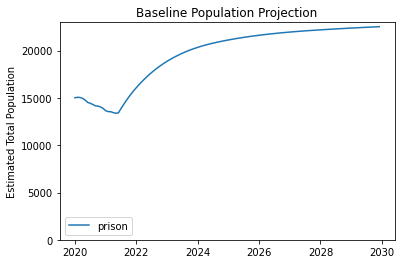

In [138]:
spark_sim.simulate_baseline(['prison'])

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  29.947766065597534
simulation_time:  21.72528910636902


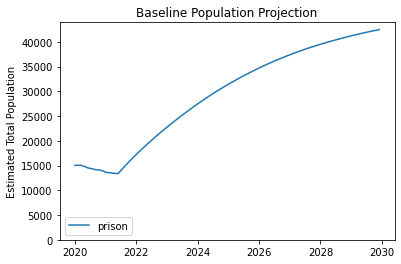

In [24]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

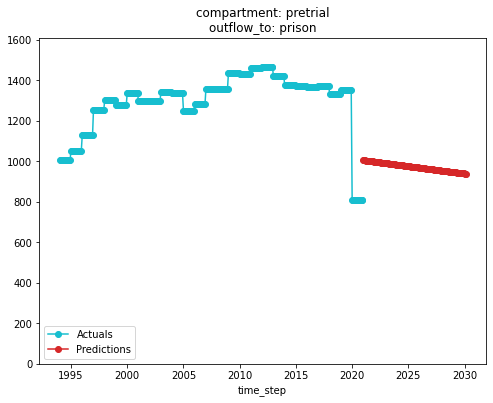

In [25]:
spark_sim.get_arima_output_plots('baseline_projections')